**The Baseline Model**

---



In [77]:
!pip install d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
!pip install matplotlib
%matplotlib inline
!pip install matplotlib-inline
import sys
!{sys.executable} -m pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim

In [80]:
class EncoderDecoder(d2l.Classifier):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        return self.decoder(dec_X, dec_state)[0]

In [81]:
def init_seq2seq(module):
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [82]:
class Seq2SeqEncoder(d2l.Encoder):  
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        embs = self.embedding(X.t().type(torch.int64))
        outputs, state = self.rnn(embs)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        context = enc_output[-1]
        context = context.repeat(embs.shape[0], 1, 1)
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        return outputs, [enc_output, hidden_state]

In [83]:
class Seq2Seq(d2l.EncoderDecoder):  
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()    

In [84]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

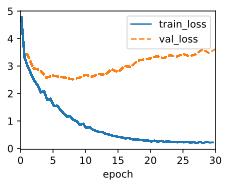

In [85]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [86]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, num_layers=2, dropout=0.2)
    )
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(214, 256)
    (rnn): GRU(
      (rnn): GRU(512, 256, num_layers=2, dropout=0.2)
    )
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [87]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─Seq2SeqEncoder: 1-1                    --
│    └─Embedding: 2-1                    49,664
│    └─GRU: 2-2                          --
│    │    └─GRU: 3-1                     789,504
├─Seq2SeqDecoder: 1-2                    --
│    └─Embedding: 2-3                    54,784
│    └─GRU: 2-4                          --
│    │    └─GRU: 3-2                     986,112
│    └─Linear: 2-5                       54,998
Total params: 1,935,062
Trainable params: 1,935,062
Non-trainable params: 0

In [ ]:
def bleu(pred_seq, label_seq, k): 
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'venu', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


**Adjusting hyperparameters- Changing embedding size and number of hidden states**



In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 64, 64, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

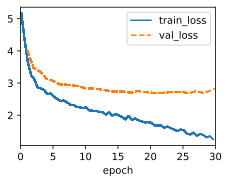

In [ ]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 64)
    (rnn): GRU(
      (rnn): GRU(64, 64, num_layers=2, dropout=0.2)
    )
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(214, 64)
    (rnn): GRU(
      (rnn): GRU(128, 64, num_layers=2, dropout=0.2)
    )
    (dense): Linear(in_features=64, out_features=214, bias=True)
  )
)

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['<unk>', '!'], bleu,0.000
i lost . => ['je', 'suis', '<unk>', '.'], bleu,0.000
he's calm . => ['<unk>', '!'], bleu,0.000
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512


**Adjusting hyperparameters- Changing batch size & Number of layers & Number of epochs**

In [ ]:
data = d2l.MTFraEng(batch_size=32)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 1, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

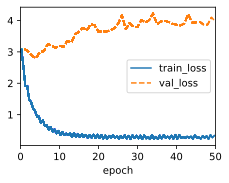

In [ ]:
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, dropout=0.2)
    )
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(214, 256)
    (rnn): GRU(
      (rnn): GRU(512, 256, dropout=0.2)
    )
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'vais', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


**Adjusting hyperparameters- Changing the dropout size**

In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.001)

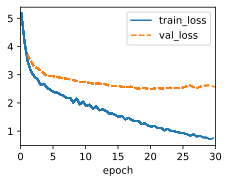

In [ ]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, num_layers=2)
    )
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(214, 256)
    (rnn): GRU(
      (rnn): GRU(512, 256, num_layers=2)
    )
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['<unk>', '!'], bleu,0.000
i lost . => ['je', 'suis', '<unk>', '.'], bleu,0.000
he's calm . => ['il', 'est', '<unk>', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'malade', '.'], bleu,0.512


**Adjusting hyperparameters- Changing the optimizer to SGD**

In [ ]:
class Seq2Seq(d2l.EncoderDecoder):  
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()    

In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


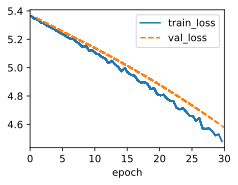

In [ ]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, num_layers=2, dropout=0.2)
    )
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(214, 256)
    (rnn): GRU(
      (rnn): GRU(512, 256, num_layers=2, dropout=0.2)
    )
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [ ]:
pip install sacrebleu


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.0 MB/s eta 0:00:00


In [ ]:
import sacrebleu

# Reference translations
refs = [['The cat is on the mat.', 'There is a cat on the mat.']]
# Candidate translation
cand = ['The cat is on the mat.']

# Calculate BLEU score
bleu = sacrebleu.corpus_bleu(cand, refs)
print(f"BLEU score: {bleu.score}")

BLEU score: 100.00000000000004


In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['<unk>'], bleu,0.000
i lost . => ['<unk>'], bleu,0.000
he's calm . => ['<unk>'], bleu,0.000
i'm home . => ['<unk>'], bleu,0.000


**Adjusting hyperparameters- Changing everything together**

In [106]:
class Seq2Seq(d2l.EncoderDecoder):  
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()    

In [123]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 64, 64, 3, 0.7
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.001)

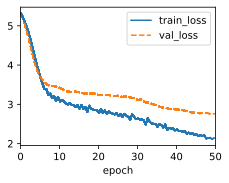

In [124]:
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [125]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 64)
    (rnn): GRU(
      (rnn): GRU(64, 64, num_layers=3, dropout=0.7)
    )
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(214, 64)
    (rnn): GRU(
      (rnn): GRU(128, 64, num_layers=3, dropout=0.7)
    )
    (dense): Linear(in_features=64, out_features=214, bias=True)
  )
)